In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, ClusterCentroids, TomekLinks

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

train_encoded = pd.read_csv('train_encoded.csv')
test_encoded = pd.read_csv('test_encoded.csv')

In [2]:
# Check for non-numeric columns in train and test
non_numeric_train = train_encoded.select_dtypes(include=['object', 'category']).columns
non_numeric_test = test_encoded.select_dtypes(include=['object', 'category']).columns

# Combine to see any remaining unique ones
remaining_to_encode = set(non_numeric_train).union(set(non_numeric_test))

print("Remaining columns to encode:", remaining_to_encode)

Remaining columns to encode: set()


In [3]:
import pandas as pd

# Calculate the class distribution
class_distribution = train_encoded['PotentialFraud'].value_counts().reset_index()
class_distribution.columns = ['PotentialFraud', 'Count']

# Calculate the percentage of each class
class_distribution['Percentage'] = (class_distribution['Count'] / class_distribution['Count'].sum()) * 100

# Display the table
print(class_distribution)

   PotentialFraud   Count  Percentage
0               0  345024    61.90859
1               1  212288    38.09141


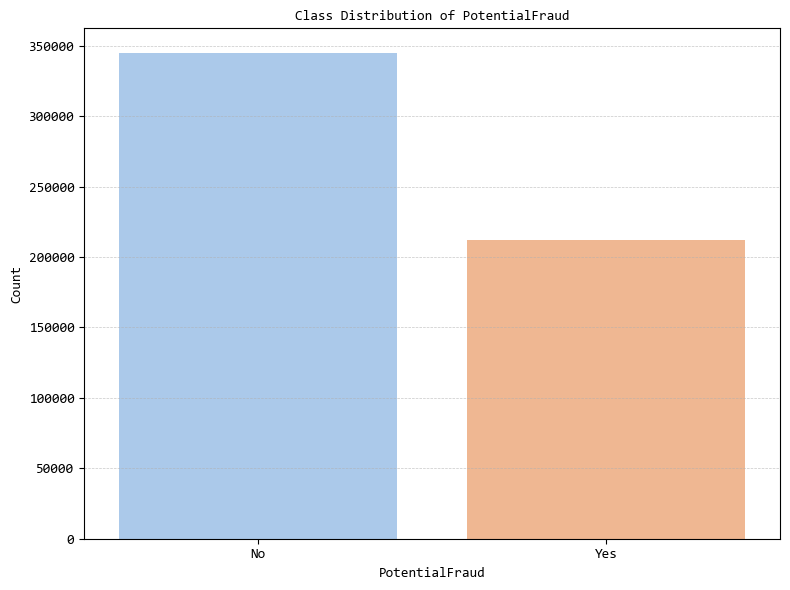

In [4]:
# Plotting the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='PotentialFraud', data=train_encoded, hue='PotentialFraud', palette='pastel', legend=False)
plt.title('Class Distribution of PotentialFraud', fontsize=10, fontname='Consolas')
plt.xlabel('PotentialFraud', fontsize=10, fontname='Consolas')
plt.ylabel('Count', fontsize=10, fontname='Consolas')

plt.xticks(ticks=[0, 1], labels=['No', 'Yes'], fontsize=10, fontname='Consolas')
plt.yticks(fontsize=10, fontname='Consolas')

plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)


plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd

def check_dataset_issues(dataset, dataset_name="Dataset"):
  
    # Check for NaN, Inf, and Negative values in the dataset
    issues = {
        'NaN Values': dataset.isna().sum(),
        'Inf Values': np.isinf(dataset).sum(),
        'Negative Values': (dataset < 0).sum()
    }
    
    # Create a DataFrame of the issues
    issues_df = pd.DataFrame(issues)
    
    # Filter columns with any issues
    issues_df = issues_df[issues_df.sum(axis=1) > 0]
    
    # Transpose for better readability
    issues_df = issues_df.T
    
    # Display the results
    print(f"\n{dataset_name} Issues:")
    display(issues_df)
    return issues_df

In [6]:
# Check issues in train dataset
train_issues = check_dataset_issues(train_encoded, "Train Dataset")


Train Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,18665
Inf Values,0,0,478036
Negative Values,57,15,0


In [7]:
# Check issues in test dataset
test_issues = check_dataset_issues(test_encoded, "Test Dataset")


Test Dataset Issues:


,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,ReimbursementDeductibleRatio
NaN Values,0,0,4458
Inf Values,0,0,116253
Negative Values,11,4,0


In [8]:
# Drop 'ReimbursementDeductibleRatio' column from both train and test datasets
train_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)
test_encoded.drop(columns='ReimbursementDeductibleRatio', inplace=True)

In [9]:
# Define target and features
X = train_encoded.drop(columns='PotentialFraud')
y = train_encoded['PotentialFraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# scale the features 
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [11]:
# Define models to evaluate
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': GaussianNB(),
    'XGBoost': xgb.XGBClassifier(),
    'LightGBM': lgb.LGBMClassifier(verbose=-1),
    'CatBoost': cb.CatBoostClassifier(silent=True),
    'Decision Tree': DecisionTreeClassifier(),
    'AdaBoost': AdaBoostClassifier(),
}

In [12]:
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cm, model_name):
    tn, fp, fn, tp = cm.ravel()
    print(f"🔢 Confusion Matrix for {model_name}:\n")
    print(f"{'':<18}{'Predicted: 0':<15}{'Predicted: 1'}")
    print(f"{'Actual: 0':<18}{tn:<15}{fp}")
    print(f"{'Actual: 1':<18}{fn:<15}{tp}")
    print("-" * 40)

print("🔍 Starting model evaluation on original (unbalanced) dataset...\n")

for model_name, model in models.items():
    print(f"\n➡️ Training model: {model_name}\n{'='*50}")
    
    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ Accuracy: {acc:.4f}")

    # Classification report
    print(f"\n📝 Classification Report for {model_name}:\n")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print_confusion_matrix(cm, model_name)

print("\n✅ All model evaluations complete.")

🔍 Starting model evaluation on original (unbalanced) dataset...


➡️ Training model: Logistic Regression
✅ Accuracy: 0.8189

📝 Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.82      0.91      0.86     69005
           1       0.82      0.67      0.74     42458

    accuracy                           0.82    111463
   macro avg       0.82      0.79      0.80    111463
weighted avg       0.82      0.82      0.81    111463

🔢 Confusion Matrix for Logistic Regression:

                  Predicted: 0   Predicted: 1
Actual: 0         62768          6237
Actual: 1         13946          28512
----------------------------------------

➡️ Training model: KNN
✅ Accuracy: 0.7247

📝 Classification Report for KNN:

              precision    recall  f1-score   support

           0       0.74      0.86      0.80     69005
           1       0.69      0.50      0.58     42458

    accuracy                           0.72    